# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

 8921088/11490434 [======================>.......] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 14:00 - loss: 0.6932

  28/1875 [..............................] - ETA: 3s - loss: 0.5478   

  55/1875 [..............................] - ETA: 3s - loss: 0.4696

  79/1875 [>.............................] - ETA: 3s - loss: 0.4314

 104/1875 [>.............................] - ETA: 3s - loss: 0.4050

 132/1875 [=>............................] - ETA: 3s - loss: 0.3836

 162/1875 [=>............................] - ETA: 3s - loss: 0.3663

 196/1875 [==>...........................] - ETA: 3s - loss: 0.3508

 229/1875 [==>...........................] - ETA: 2s - loss: 0.3386

 264/1875 [===>..........................] - ETA: 2s - loss: 0.3278

 301/1875 [===>..........................] - ETA: 2s - loss: 0.3180

 332/1875 [====>.........................] - ETA: 2s - loss: 0.3108

 363/1875 [====>.........................] - ETA: 2s - loss: 0.3044

 397/1875 [=====>........................] - ETA: 2s - loss: 0.2980

 434/1875 [=====>........................] - ETA: 2s - loss: 0.2917

 470/1875 [======>.......................] - ETA: 2s - loss: 0.2862

 505/1875 [=======>......................] - ETA: 2s - loss: 0.2813

 541/1875 [=======>......................] - ETA: 2s - loss: 0.2766

 576/1875 [========>.....................] - ETA: 2s - loss: 0.2724

 612/1875 [========>.....................] - ETA: 1s - loss: 0.2684

 648/1875 [=========>....................] - ETA: 1s - loss: 0.2646

 682/1875 [=========>....................] - ETA: 1s - loss: 0.2613

 718/1875 [==========>...................] - ETA: 1s - loss: 0.2580

 755/1875 [===========>..................] - ETA: 1s - loss: 0.2547

 791/1875 [===========>..................] - ETA: 1s - loss: 0.2518

 821/1875 [============>.................] - ETA: 1s - loss: 0.2495

 850/1875 [============>.................] - ETA: 1s - loss: 0.2473

 877/1875 [=============>................] - ETA: 1s - loss: 0.2454

 906/1875 [=============>................] - ETA: 1s - loss: 0.2434

 933/1875 [=============>................] - ETA: 1s - loss: 0.2416

 955/1875 [==============>...............] - ETA: 1s - loss: 0.2401

 980/1875 [==============>...............] - ETA: 1s - loss: 0.2386

1006/1875 [===============>..............] - ETA: 1s - loss: 0.2370

1033/1875 [===============>..............] - ETA: 1s - loss: 0.2354

1060/1875 [===============>..............] - ETA: 1s - loss: 0.2339

1090/1875 [================>.............] - ETA: 1s - loss: 0.2322

1114/1875 [================>.............] - ETA: 1s - loss: 0.2309

1144/1875 [=================>............] - ETA: 1s - loss: 0.2294

1176/1875 [=================>............] - ETA: 1s - loss: 0.2278

1204/1875 [==================>...........] - ETA: 1s - loss: 0.2264

1235/1875 [==================>...........] - ETA: 1s - loss: 0.2250

1264/1875 [===================>..........] - ETA: 1s - loss: 0.2236

1293/1875 [===================>..........] - ETA: 0s - loss: 0.2223

1322/1875 [====================>.........] - ETA: 0s - loss: 0.2211

1351/1875 [====================>.........] - ETA: 0s - loss: 0.2199

1381/1875 [=====================>........] - ETA: 0s - loss: 0.2186

1410/1875 [=====================>........] - ETA: 0s - loss: 0.2175

1438/1875 [======================>.......] - ETA: 0s - loss: 0.2164

1466/1875 [======================>.......] - ETA: 0s - loss: 0.2153

1496/1875 [======================>.......] - ETA: 0s - loss: 0.2142

1526/1875 [=======================>......] - ETA: 0s - loss: 0.2131

1557/1875 [=======================>......] - ETA: 0s - loss: 0.2120

1588/1875 [========================>.....] - ETA: 0s - loss: 0.2109

1617/1875 [========================>.....] - ETA: 0s - loss: 0.2099

1647/1875 [=========================>....] - ETA: 0s - loss: 0.2090

1677/1875 [=========================>....] - ETA: 0s - loss: 0.2080

1708/1875 [==========================>...] - ETA: 0s - loss: 0.2070

1738/1875 [==========================>...] - ETA: 0s - loss: 0.2061

1767/1875 [===========================>..] - ETA: 0s - loss: 0.2052

1796/1875 [===========================>..] - ETA: 0s - loss: 0.2043

1823/1875 [============================>.] - ETA: 0s - loss: 0.2036

1849/1875 [============================>.] - ETA: 0s - loss: 0.2028

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2021


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1344

  28/1875 [..............................] - ETA: 3s - loss: 0.1136

  58/1875 [..............................] - ETA: 3s - loss: 0.1119

  89/1875 [>.............................] - ETA: 3s - loss: 0.1111

 115/1875 [>.............................] - ETA: 3s - loss: 0.1107

 144/1875 [=>............................] - ETA: 3s - loss: 0.1104

 172/1875 [=>............................] - ETA: 3s - loss: 0.1102

 202/1875 [==>...........................] - ETA: 2s - loss: 0.1100

 233/1875 [==>...........................] - ETA: 2s - loss: 0.1099

 262/1875 [===>..........................] - ETA: 2s - loss: 0.1098

 288/1875 [===>..........................] - ETA: 2s - loss: 0.1098

 311/1875 [===>..........................] - ETA: 2s - loss: 0.1097

 341/1875 [====>.........................] - ETA: 2s - loss: 0.1096

 370/1875 [====>.........................] - ETA: 2s - loss: 0.1095

 401/1875 [=====>........................] - ETA: 2s - loss: 0.1094

 426/1875 [=====>........................] - ETA: 2s - loss: 0.1094

 457/1875 [======>.......................] - ETA: 2s - loss: 0.1093

 485/1875 [======>.......................] - ETA: 2s - loss: 0.1092

 515/1875 [=======>......................] - ETA: 2s - loss: 0.1091

 546/1875 [=======>......................] - ETA: 2s - loss: 0.1091

 576/1875 [========>.....................] - ETA: 2s - loss: 0.1090

 606/1875 [========>.....................] - ETA: 2s - loss: 0.1089

 636/1875 [=========>....................] - ETA: 2s - loss: 0.1089

 665/1875 [=========>....................] - ETA: 2s - loss: 0.1088

 693/1875 [==========>...................] - ETA: 2s - loss: 0.1087

 722/1875 [==========>...................] - ETA: 2s - loss: 0.1087

 751/1875 [===========>..................] - ETA: 1s - loss: 0.1086

 781/1875 [===========>..................] - ETA: 1s - loss: 0.1085

 811/1875 [===========>..................] - ETA: 1s - loss: 0.1085

 841/1875 [============>.................] - ETA: 1s - loss: 0.1084

 870/1875 [============>.................] - ETA: 1s - loss: 0.1083

 900/1875 [=============>................] - ETA: 1s - loss: 0.1082

 930/1875 [=============>................] - ETA: 1s - loss: 0.1082

 961/1875 [==============>...............] - ETA: 1s - loss: 0.1081

 991/1875 [==============>...............] - ETA: 1s - loss: 0.1080

1022/1875 [===============>..............] - ETA: 1s - loss: 0.1080

1051/1875 [===============>..............] - ETA: 1s - loss: 0.1079

1081/1875 [================>.............] - ETA: 1s - loss: 0.1078

1112/1875 [================>.............] - ETA: 1s - loss: 0.1078

1141/1875 [=================>............] - ETA: 1s - loss: 0.1077

1170/1875 [=================>............] - ETA: 1s - loss: 0.1076

1199/1875 [==================>...........] - ETA: 1s - loss: 0.1076

1230/1875 [==================>...........] - ETA: 1s - loss: 0.1075

1257/1875 [===================>..........] - ETA: 1s - loss: 0.1074

1288/1875 [===================>..........] - ETA: 1s - loss: 0.1074

1316/1875 [====================>.........] - ETA: 0s - loss: 0.1073

1345/1875 [====================>.........] - ETA: 0s - loss: 0.1072

1374/1875 [====================>.........] - ETA: 0s - loss: 0.1072

1405/1875 [=====================>........] - ETA: 0s - loss: 0.1071

1431/1875 [=====================>........] - ETA: 0s - loss: 0.1071

1461/1875 [======================>.......] - ETA: 0s - loss: 0.1070

1492/1875 [======================>.......] - ETA: 0s - loss: 0.1070

1522/1875 [=======================>......] - ETA: 0s - loss: 0.1069

1549/1875 [=======================>......] - ETA: 0s - loss: 0.1068

1578/1875 [========================>.....] - ETA: 0s - loss: 0.1068

1601/1875 [========================>.....] - ETA: 0s - loss: 0.1067

1626/1875 [=========================>....] - ETA: 0s - loss: 0.1067

1654/1875 [=========================>....] - ETA: 0s - loss: 0.1066

1682/1875 [=========================>....] - ETA: 0s - loss: 0.1066

1706/1875 [==========================>...] - ETA: 0s - loss: 0.1065

1735/1875 [==========================>...] - ETA: 0s - loss: 0.1065

1768/1875 [===========================>..] - ETA: 0s - loss: 0.1064

1793/1875 [===========================>..] - ETA: 0s - loss: 0.1064

1821/1875 [============================>.] - ETA: 0s - loss: 0.1063

1850/1875 [============================>.] - ETA: 0s - loss: 0.1063

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1062


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1022

  34/1875 [..............................] - ETA: 2s - loss: 0.0991

  62/1875 [..............................] - ETA: 3s - loss: 0.0993

  93/1875 [>.............................] - ETA: 2s - loss: 0.0994

 121/1875 [>.............................] - ETA: 2s - loss: 0.0994

 147/1875 [=>............................] - ETA: 3s - loss: 0.0994

 172/1875 [=>............................] - ETA: 3s - loss: 0.0994

 203/1875 [==>...........................] - ETA: 2s - loss: 0.0994

 225/1875 [==>...........................] - ETA: 3s - loss: 0.0994

 253/1875 [===>..........................] - ETA: 2s - loss: 0.0993

 283/1875 [===>..........................] - ETA: 2s - loss: 0.0993

 314/1875 [====>.........................] - ETA: 2s - loss: 0.0992

 339/1875 [====>.........................] - ETA: 2s - loss: 0.0991

 366/1875 [====>.........................] - ETA: 2s - loss: 0.0991

 392/1875 [=====>........................] - ETA: 2s - loss: 0.0991

 418/1875 [=====>........................] - ETA: 2s - loss: 0.0990

 447/1875 [======>.......................] - ETA: 2s - loss: 0.0990

 473/1875 [======>.......................] - ETA: 2s - loss: 0.0989

 503/1875 [=======>......................] - ETA: 2s - loss: 0.0989

 530/1875 [=======>......................] - ETA: 2s - loss: 0.0989

 558/1875 [=======>......................] - ETA: 2s - loss: 0.0988

 587/1875 [========>.....................] - ETA: 2s - loss: 0.0988

 618/1875 [========>.....................] - ETA: 2s - loss: 0.0988

 650/1875 [=========>....................] - ETA: 2s - loss: 0.0987

 682/1875 [=========>....................] - ETA: 2s - loss: 0.0987

 714/1875 [==========>...................] - ETA: 2s - loss: 0.0987

 746/1875 [==========>...................] - ETA: 2s - loss: 0.0986

 777/1875 [===========>..................] - ETA: 1s - loss: 0.0986

 810/1875 [===========>..................] - ETA: 1s - loss: 0.0986

 838/1875 [============>.................] - ETA: 1s - loss: 0.0985

 869/1875 [============>.................] - ETA: 1s - loss: 0.0985

 901/1875 [=============>................] - ETA: 1s - loss: 0.0985

 934/1875 [=============>................] - ETA: 1s - loss: 0.0984

 966/1875 [==============>...............] - ETA: 1s - loss: 0.0984

 998/1875 [==============>...............] - ETA: 1s - loss: 0.0984

1031/1875 [===============>..............] - ETA: 1s - loss: 0.0984

1063/1875 [================>.............] - ETA: 1s - loss: 0.0983

1087/1875 [================>.............] - ETA: 1s - loss: 0.0983

1111/1875 [================>.............] - ETA: 1s - loss: 0.0983

1142/1875 [=================>............] - ETA: 1s - loss: 0.0983

1165/1875 [=================>............] - ETA: 1s - loss: 0.0983

1195/1875 [==================>...........] - ETA: 1s - loss: 0.0983

1222/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1252/1875 [===================>..........] - ETA: 1s - loss: 0.0982

1278/1875 [===================>..........] - ETA: 1s - loss: 0.0982

1308/1875 [===================>..........] - ETA: 0s - loss: 0.0982

1336/1875 [====================>.........] - ETA: 0s - loss: 0.0982

1360/1875 [====================>.........] - ETA: 0s - loss: 0.0982

1388/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1413/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1438/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1464/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1490/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1519/1875 [=======================>......] - ETA: 0s - loss: 0.0981

1545/1875 [=======================>......] - ETA: 0s - loss: 0.0981

1573/1875 [========================>.....] - ETA: 0s - loss: 0.0981

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0981

1635/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1666/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1787/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1811/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1838/1875 [============================>.] - ETA: 0s - loss: 0.0980

1864/1875 [============================>.] - ETA: 0s - loss: 0.0979

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0979


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1020

  32/1875 [..............................] - ETA: 3s - loss: 0.0954

  61/1875 [..............................] - ETA: 3s - loss: 0.0951

  91/1875 [>.............................] - ETA: 3s - loss: 0.0952

 121/1875 [>.............................] - ETA: 2s - loss: 0.0952

 150/1875 [=>............................] - ETA: 2s - loss: 0.0952

 180/1875 [=>............................] - ETA: 2s - loss: 0.0953

 211/1875 [==>...........................] - ETA: 2s - loss: 0.0954

 241/1875 [==>...........................] - ETA: 2s - loss: 0.0954

 270/1875 [===>..........................] - ETA: 2s - loss: 0.0954

 300/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 331/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 361/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 384/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 411/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 439/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 469/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 500/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 532/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 564/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 596/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 629/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 661/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 693/1875 [==========>...................] - ETA: 1s - loss: 0.0957

 726/1875 [==========>...................] - ETA: 1s - loss: 0.0957

 758/1875 [===========>..................] - ETA: 1s - loss: 0.0957

 790/1875 [===========>..................] - ETA: 1s - loss: 0.0957

 822/1875 [============>.................] - ETA: 1s - loss: 0.0957

 854/1875 [============>.................] - ETA: 1s - loss: 0.0957

 886/1875 [=============>................] - ETA: 1s - loss: 0.0958

 918/1875 [=============>................] - ETA: 1s - loss: 0.0958

 950/1875 [==============>...............] - ETA: 1s - loss: 0.0958

 982/1875 [==============>...............] - ETA: 1s - loss: 0.0958

1015/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1047/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1079/1875 [================>.............] - ETA: 1s - loss: 0.0958

1112/1875 [================>.............] - ETA: 1s - loss: 0.0958

1144/1875 [=================>............] - ETA: 1s - loss: 0.0958

1176/1875 [=================>............] - ETA: 1s - loss: 0.0958

1208/1875 [==================>...........] - ETA: 1s - loss: 0.0958

1239/1875 [==================>...........] - ETA: 1s - loss: 0.0958

1270/1875 [===================>..........] - ETA: 0s - loss: 0.0958

1297/1875 [===================>..........] - ETA: 0s - loss: 0.0958

1326/1875 [====================>.........] - ETA: 0s - loss: 0.0958

1355/1875 [====================>.........] - ETA: 0s - loss: 0.0958

1384/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1415/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1444/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1467/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1498/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1528/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1551/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1579/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1607/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1670/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1763/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1793/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1825/1875 [============================>.] - ETA: 0s - loss: 0.0959

1857/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0955

  33/1875 [..............................] - ETA: 2s - loss: 0.0970

  64/1875 [>.............................] - ETA: 2s - loss: 0.0967

  95/1875 [>.............................] - ETA: 2s - loss: 0.0965

 127/1875 [=>............................] - ETA: 2s - loss: 0.0964

 160/1875 [=>............................] - ETA: 2s - loss: 0.0963

 192/1875 [==>...........................] - ETA: 2s - loss: 0.0962

 225/1875 [==>...........................] - ETA: 2s - loss: 0.0961

 257/1875 [===>..........................] - ETA: 2s - loss: 0.0961

 288/1875 [===>..........................] - ETA: 2s - loss: 0.0960

 319/1875 [====>.........................] - ETA: 2s - loss: 0.0959

 351/1875 [====>.........................] - ETA: 2s - loss: 0.0959

 383/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 415/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 447/1875 [======>.......................] - ETA: 2s - loss: 0.0958

 479/1875 [======>.......................] - ETA: 2s - loss: 0.0957

 511/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 543/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 575/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 607/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 639/1875 [=========>....................] - ETA: 1s - loss: 0.0956

 671/1875 [=========>....................] - ETA: 1s - loss: 0.0956

 703/1875 [==========>...................] - ETA: 1s - loss: 0.0956

 734/1875 [==========>...................] - ETA: 1s - loss: 0.0956

 765/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 796/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 827/1875 [============>.................] - ETA: 1s - loss: 0.0955

 858/1875 [============>.................] - ETA: 1s - loss: 0.0955

 890/1875 [=============>................] - ETA: 1s - loss: 0.0955

 921/1875 [=============>................] - ETA: 1s - loss: 0.0955

 952/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 983/1875 [==============>...............] - ETA: 1s - loss: 0.0955

1015/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1077/1875 [================>.............] - ETA: 1s - loss: 0.0955

1108/1875 [================>.............] - ETA: 1s - loss: 0.0955

1139/1875 [=================>............] - ETA: 1s - loss: 0.0955

1169/1875 [=================>............] - ETA: 1s - loss: 0.0954

1199/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1230/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1259/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1289/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1321/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1352/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1383/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1414/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1476/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1507/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1536/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1566/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1591/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1620/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1647/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1677/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1705/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1736/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1823/1875 [============================>.] - ETA: 0s - loss: 0.0954

1854/1875 [============================>.] - ETA: 0s - loss: 0.0954

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0954


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

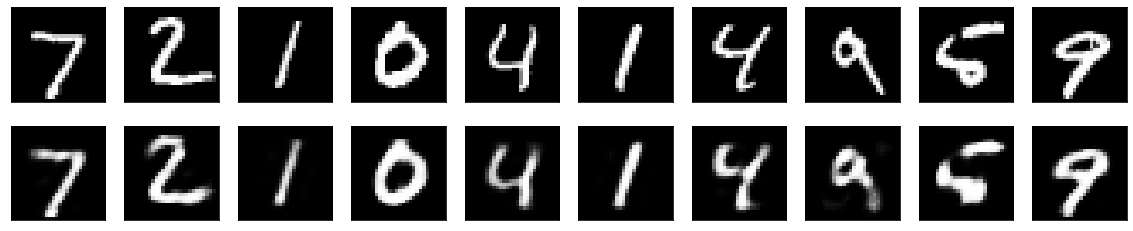

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
